<a href="https://colab.research.google.com/github/valentine96/Demand-Planning-and-Forecasting/blob/main/notebooks/01_Data_Cleaning_and__EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for Demand Planning and Forecasting in Retail and FMCG**

In this project, we adopt the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework, which guides the entire workflow from Business Understanding → Data Understanding → Data Preparation → Modeling → Evaluation → Deployment.

## **1. Business Understanding**
### **1.1 Background**

Accurate demand forecasting is one of the most critical functions in the retail and FMCG industry. Supermarkets and manufacturers must constantly balance between:

Stockouts, which lead to lost sales, customer dissatisfaction, and weakened brand loyalty.

Overstocking, which increases holding costs, ties up working capital, and often results in product waste.

In dynamic retail environments where sales are influenced by promotions, holidays, seasonality, and store characteristics, traditional forecasting techniques often fail to capture real-world complexity.

This project focuses on developing a machine-learning–driven demand forecasting model to support retail planning and operational decision-making.

### **1.2 Business Objective**

The goal of this project is to design and evaluate a demand forecasting system that:

- Predicts daily store-level sales accurately.

- Captures the effect of promotions, competition, holidays, seasonality, and store attributes.

- Enables the business to make informed decisions for:

    - replenishment planning

    - promo planning

    - distribution scheduling

    - production and inventory alignment

Ultimately, the project aims to reduce forecasting error, resulting in:

- Fewer stockouts
- Lower overstock and carrying costs
- Improved operational efficiency

### **1.3 Project Scope**
The project covers the following:

- End-to-end development of a demand forecasting pipeline.
- Exploratory analysis of sales behavior, seasonality patterns, and external drivers.
- Feature engineering to enrich the predictive power of the dataset.
- Model experimentation using:

    - Seasonal Naïve Baseline Model (benchmark)

    - Facebook Prophet (tested but later rejected due to poor performance)

    - LightGBM (selected final model)

- Model evaluation using industry-relevant metrics (RMSE, MAPE, WAPE).
- Interpretability using SHAP for insights into key sales drivers.
- Development of a simple forecasting output for dashboard integration.

## **2. Data Understanding**
The dataset used in this project originates from the Rossmann Store Sales dataset, a widely used benchmark for retail demand forecasting. It was originally provided for a Kaggle competition where the objective was to forecast daily sales for over 1,000 pharmacy retail stores across several regions.

The dataset offers an excellent real-world structure for modeling FMCG demand because it includes:

- Daily sales across many stores
- Promotional information
- Store-level characteristics
- Holiday and competition effects
- Several years of historical records

This makes it highly relevant for our forecasting objectives and ideal for demonstrating the full CRISP-DM workflow.

###**2.1 Overview of the three datasets**
The project uses three datasets:

**1. train.csv**

This file contains daily sales observations for each store.
It serves as the primary dataset for training the forecasting model.

- Store - Unique store ID
- DayOfWeek - Day of the week (1 = Monday, 7 = Sunday)
- Date -Transaction date
- Sales	Target variable — daily revenue
- Customers - Number of customers visiting the store
- Open - Store open/closed indicator (1 = open, 0 = closed)
- Promo -	Whether a promotion was active that day
- StateHoliday - Public/state holiday indicator (a, b, c, 0)
- SchoolHoliday- Whether schools were closed that day

**2. test.csv**

This file mirrors the structure of train.csv, but Sales and Customers are missing because they must be predicted.

- Store - Store ID
- DayOfWeek - Day of the week
- Date - Forecasting date
- Open - Whether the store is open
- Promo	- Promotion indicator
- StateHoliday - Public/state holiday
- SchoolHoliday - School holiday indicator

**3. store.csv**

This dataset contains static attributes that describe each store’s long-term characteristics.
These features explain why stores behave differently even under similar conditions.
- StoreType -	Category of the store (a,b,c,d)
- Assortment -	Level of product variety (basic, extra, extended)
- CompetitionDistance	- Distance to nearest competitor (meters)
- CompetitionOpenSinceMonth	- Month competitor store opened
- CompetitionOpenSinceYear -	Year competitor opened
- Promo2 - Continuous promotion program flag
- Promo2SinceWeek - 	Week Promo2 started
- Promo2SinceYear	- Year Promo2 started
- PromoInterval -	Months when Promo2 runs (e.g., Jan,Apr,Jul,Oct)

##**2.2 Load the Datasets**

In [ ]:
# Imports neccesary libraries & configuration

# Numerical and data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Seasonal decomposition for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# Performance metrics for evaluating forecasting models
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore unnecessary warnings to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

# Set a consistent plotting style for clean visuals
sns.set(style="whitegrid", font_scale=1.1)

# Display all dataframe columns without truncation
pd.set_option("display.max_columns", None)

# Helper Metric Functions

def rmse(y_true, y_pred):
    """Compute Root Mean Squared Error (RMSE) — measures forecast accuracy."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    """Compute Mean Absolute Percentage Error (MAPE) — measures percentage error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100

def wape(y_true, y_pred):
    """Compute Weighted Absolute Percentage Error (WAPE) — useful for retail datasets."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100


In [ ]:
# mount google drive since the data is in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to our shared Capstone_Data folder
path = "/content/drive/MyDrive/Capstone_Data/"

# Load the datasets
train_df = pd.read_csv(path + "train.csv")
test_df  = pd.read_csv(path + "test.csv")
store_df = pd.read_csv(path + "store.csv")

## **2.3 Inspect Datasets Structure**
###**2.3.1 Inspect the train dataset**

What we observed:

- Contains 1,017,209 rows  and 9 columns
- No missing values detected across all columns.
- No duplicate records found.
- Column types are mostly numerical (int64), except Date, StateHoliday, and SchoolHoliday, which appear as object types.
- The preview confirms expected fields: Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday.

  - Some categorical columns stored as object types will need encoding later.

  - The Date column must be converted to datetime type during preprocessing.

In [ ]:
# train set shape
print("Train shape:", train_df.shape)

# Dataset previews
print("\nTRAIN SET PREVIEW")
display(train_df.head())

print("\n TRAIN DATA: Missing Values")
print(train_df.isna().sum())

print("\n TRAIN DATA: Duplicate Records")
print(train_df.duplicated().sum())

# Dataset info (structure, types, missing values)
print("\nTRAIN DATA INFO")
train_df.info()

Train shape: (1017209, 9)

TRAIN SET PREVIEW


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1



 TRAIN DATA: Missing Values
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

 TRAIN DATA: Duplicate Records
0

TRAIN DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


###**2.3.2 Inspect the test dataset**
What we observed:
- Shape: 41,088 rows × 8 columns.
- No missing values except for column Open, which has 11 missing entries.
- No duplicate records found.
- Structure aligns with expectations: same columns as train but without Sales and Customers columns

  - Missing values in Open will need imputation—typically setting closed stores (Open = 0) or defaulting to 1 based on business rules
  - Same type inconsistencies as train: Date and some categorical values stored as objects.

In [ ]:
# train set shape
print("Test shape:", test_df.shape)

# Dataset previews
print("\nTEST SET PREVIEW")
display(test_df.head())

print("\n TEST DATA: Missing Values")
print(test_df.isna().sum())

print("\n TEST DATA: Duplicate Records")
print(test_df.duplicated().sum())

# Dataset info (structure, types, missing values)
print("\nTEST DATA INFO")
test_df.info()

Test shape: (41088, 8)

TEST SET PREVIEW


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0



 TEST DATA: Missing Values
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

 TEST DATA: Duplicate Records
0

TEST DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


###**2.3.3 Inspect the store dataset**

What we observed:

- Contains 1,115 rows and 10 columns, representing each store once.
- Significant missing values in long-term attributes:
- CompetitionOpenSinceMonth, CompetitionOpenSinceYear: missing in 354 stores
- Promo2SinceWeek, Promo2SinceYear, PromoInterval: missing in 544 stores
- No duplicate records observed.
- Mix of int64, float64, and object types.

What this means:
- Missing values are expected because many stores do not participate in Promo2 or lack competition data.
- These missing values are not errors and will be handled logically:
- Fill nulls for Promo2-related features with 0 or “None”
- Replace missing competition dates with reasonable defaults (e.g., 0 or the store’s opening year)

In [ ]:
# Dataset shapes
print("Store shape:", store_df.shape)

# Dataset previews
print("\nSTORE METADATA PREVIEW")
display(store_df.head())

print("\n STORE DATA: Missing Values")
print(store_df.isna().sum())

print("\n STORE DATA: Duplicate Records")
print(store_df.duplicated().sum())

# Dataset info (structure, types, missing values)
print("\nSTORE DATA INFO")
store_df.info()


Store shape: (1115, 10)

STORE METADATA PREVIEW


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN



 STORE DATA: Missing Values
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

 STORE DATA: Duplicate Records
0

STORE DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2           

# **3. Data Preparation**

Before cleaning each dataset, we apply practical rules used in retail forecasting (Guided by Rossmann Business Logic):

- Promo2 logic:
Stores not in Promo2 should have:
Promo2SinceWeek = 0, Promo2SinceYear = 0, PromoInterval = "None".

- Competition distance:
Missing CompetitionDistance means "unknown," not zero → fill using the median to avoid distortion.

- Competition open dates:
Missing CompetitionOpenSinceMonth or CompetitionOpenSinceYear indicates no documented information → set both to 0.

These rules ensure consistent, interpretable data before merging the train, test, and store datasets.

## **3.1 Clean the train set**

- The date column was converted into a proper datetime format to support time-series operations.
- Holiday indicators (StateHoliday, SchoolHoliday) and promotion flags (Promo, Open) were standardized and cast into appropriate data types.
- Negative values in numerical fields (Sales, Customers) were capped at zero to ensure valid demand patterns.
- The dataset was sorted chronologically to maintain temporal order—critical for forecasting models.
- Duplicate checks had been performed earlier, and no duplicates were found; therefore, no removal was required.

In [ ]:
# Create a copy of the dataset
train_clean = train_df.copy()

# Convert Date to datetime
train_clean['Date'] = pd.to_datetime(train_clean['Date'], errors='coerce')

# Standardize StateHoliday
#    '0' means no holiday; a/b/c represent types
train_clean['StateHoliday'] = train_clean['StateHoliday'].astype(str)
train_clean['StateHoliday'] = train_clean['StateHoliday'].replace({'0': '0', 'a': 'a', 'b': 'b', 'c': 'c'})

# Ensure correct dtypes for categorical fields
train_clean['StateHoliday'] = train_clean['StateHoliday'].astype('category')
train_clean['SchoolHoliday'] = train_clean['SchoolHoliday'].astype('int')
train_clean['Promo'] = train_clean['Promo'].astype('int')
train_clean['Open'] = train_clean['Open'].astype('int')

# Check and fix negative values
numeric_cols = ['Sales', 'Customers']
for col in numeric_cols:
    train_clean[col] = train_clean[col].clip(lower=0)

# Sort by Date (important for time-series)
train_clean = train_clean.sort_values(by='Date')
train_clean.reset_index(drop=True, inplace=True)

In [18]:
# Verify train dataset after cleaning
print("Missing Values After Cleaning (Train)")
print(train_clean.isna().sum())
print("\n")

print("Duplicate Rows (Train)")
print(train_clean.duplicated().sum())
print("\n")

print("Data Types (Train)")
print(train_clean.dtypes)
print("\n")

print("Unique Values in Key Categorical Columns (Train)")
cat_cols = ['StateHoliday', 'SchoolHoliday', 'Promo', 'Open']
for col in cat_cols:
    print(f"{col}: {train_clean[col].unique()}")
print("\n")

print("Check for invalid or coerced dates (NaT values)")
print(train_clean['Date'].isna().sum())
print("\n")

print("Basic Sanity Checks")
print("Any negative Sales?", (train_clean['Sales'] < 0).any())
print("Any negative Customers?", (train_clean['Customers'] < 0).any())



Missing Values After Cleaning (Train)
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


Duplicate Rows (Train)
0


Data Types (Train)
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday           category
SchoolHoliday             int64
dtype: object


Unique Values in Key Categorical Columns (Train)
StateHoliday: ['a', '0', 'b', 'c']
Categories (4, object): ['0', 'a', 'b', 'c']
SchoolHoliday: [1 0]
Promo: [0 1]
Open: [0 1]


Check for invalid or coerced dates (NaT values)
0


Basic Sanity Checks
Any negative Sales? False
Any negative Customers? False


## **3.2 Clean the test set**

- The Date field was converted to datetime format to support time-series consistency.
- Holiday categories were standardized to match the training dataset (0, a, b, c).
- Promotion and school holiday fields were converted to integer types for modeling.
- Missing values in the Open column were imputed using the business rule from the Rossmann dataset (“if unknown, assume the store was open”).
- The dataset was sorted chronologically to preserve temporal order.

As confirmed earlier, the test dataset contained no duplicate rows and no invalid data structure issues.

In [13]:
# create a copy of the test dataset
test_clean = test_df.copy()

# Convert Date to datetime
test_clean['Date'] = pd.to_datetime(test_clean['Date'], errors='coerce')

# Standardize StateHoliday to match train
test_clean['StateHoliday'] = test_clean['StateHoliday'].astype(str)
test_clean['StateHoliday'] = test_clean['StateHoliday'].replace({'0': '0', 'a': 'a', 'b': 'b', 'c': 'c'})
test_clean['StateHoliday'] = test_clean['StateHoliday'].astype('category')

# Fix datatype issues
test_clean['Promo'] = test_clean['Promo'].astype(int)
test_clean['SchoolHoliday'] = test_clean['SchoolHoliday'].astype(int)

# Convert 'Open' and handle missing values
# Kaggle business rule: missing = store assumed open (Open=1)
test_clean['Open'] = test_clean['Open'].fillna(1).astype(int)

# Sort by date
test_clean = test_clean.sort_values(by='Date').reset_index(drop=True)


In [15]:
# Verify test datset after cleaning
print("Missing Values After Cleaning:")
display(test_clean.isna().sum())

print("\n Duplicate Rows:")
print(test_clean.duplicated().sum())

print("\n Data Types:")
display(test_clean.dtypes)

print("\n Unique Values in Key Categorical Columns:")
print("StateHoliday:", test_clean['StateHoliday'].unique())
print("Promo:", test_clean['Promo'].unique())
print("SchoolHoliday:", test_clean['SchoolHoliday'].unique())
print("Open:", test_clean['Open'].unique())

print("\n Check for invalid or coerced dates (NaT values):")
print(test_clean['Date'].isna().sum())


Missing Values After Cleaning:


,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0



 Duplicate Rows:
0

 Data Types:


,0
Id,int64
Store,int64
DayOfWeek,int64
Date,datetime64[ns]
Open,int64
Promo,int64
StateHoliday,category
SchoolHoliday,int64



 Unique Values in Key Categorical Columns:
StateHoliday: ['0', 'a']
Categories (2, object): ['0', 'a']
Promo: [0 1]
SchoolHoliday: [1 0]
Open: [1 0]

 Check for invalid or coerced dates (NaT values):
0


## **3.3 Clean the store set**

- No missing values remain — all fields including competition and promotion details are fully populated.
- No duplicate store entries — the dataset correctly contains 1,115 unique stores.
- Categorical fields cleaned and standardized — StoreType, Assortment, and PromoInterval correctly converted to categorical types.
- Promo2 information fixed — inactive stores assigned consistent zeros/"None", and missing values for active stores properly filled.
- Competition distance outliers capped — extreme values trimmed at the 99th percentile to reduce noise.
- Dataset fully aligned with train/test — variable formats, categories, and datatypes are now consistent across all datasets, ensuring smooth merging.

In [19]:
# create a copy of the store dataset
store_clean = store_df.copy()

# Fix CompetitionDistance missing values
# Use median (robust to outliers)
store_clean['CompetitionDistance'].fillna(store_clean['CompetitionDistance'].median(), inplace=True)

# Fix Competition Open fields
# Missing = no competition info -> set to 0
store_clean['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store_clean['CompetitionOpenSinceYear'].fillna(0, inplace=True)

# Fix Promo2 related fields
# If Promo2 == 0 → there is no promo program
store_clean.loc[store_clean['Promo2'] == 0, 'Promo2SinceWeek'] = 0
store_clean.loc[store_clean['Promo2'] == 0, 'Promo2SinceYear'] = 0
store_clean.loc[store_clean['Promo2'] == 0, 'PromoInterval'] = "None"

# For Promo2==1, still fill missing values sensibly
store_clean['Promo2SinceWeek'].fillna(0, inplace=True)
store_clean['Promo2SinceYear'].fillna(0, inplace=True)
store_clean['PromoInterval'].fillna("None", inplace=True)

# Convert categorical columns
store_clean['StoreType'] = store_clean['StoreType'].astype('category')
store_clean['Assortment'] = store_clean['Assortment'].astype('category')
store_clean['PromoInterval'] = store_clean['PromoInterval'].astype('category')

# Handle extreme outliers in CompetitionDistance:
# Some stores have unrealistically large distances (e.g., >700,000 meters).
# Such extreme values can distort the model, so we cap the distance at the 99th percentile.
q99 = store_clean['CompetitionDistance'].quantile(0.99)
store_clean['CompetitionDistance'] = store_clean['CompetitionDistance'].clip(upper=q99)



In [20]:
# Verify store data after cleaning
print("Missing Values After Cleaning:")
print(store_clean.isna().sum())

print("\nDuplicate Rows:")
print(store_clean.duplicated().sum())

print("\nData Types:")
print(store_clean.dtypes)

print("\nUnique Values in Key Categorical Columns:")
print("StoreType:", store_clean['StoreType'].unique())
print("Assortment:", store_clean['Assortment'].unique())
print("PromoInterval:", store_clean['PromoInterval'].unique())


Missing Values After Cleaning:
Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Duplicate Rows:
0

Data Types:
Store                           int64
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                          int64
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                category
dtype: object

Unique Values in Key Categorical Columns:
StoreType: ['c', 'a', 'd', 'b']
Categories (4, object): ['a', 'b', 'c', 'd']
Assortment: ['a', 'c', 'b']
Categories (3, object): ['a', 'b', 'c']
PromoInterval: ['None', 'Jan,Apr

## **3.4 Datasets Merging**

We merged the cleaned train and test datasets with the store metadata using a left join on the Store column to enrich each daily record with store-level characteristics. This ensured that both datasets received consistent information on store type, assortment, competition, and promotional programs, creating a fully unified and modeling-ready dataset

In [21]:
# MERGE TRAIN WITH STORE METADATA
train_merged = train_clean.merge(store_clean, on="Store", how="left")

print("Merged Train Shape:", train_merged.shape)
train_merged.head()

Merged Train Shape: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,0.0,0.0,0,0.0,0.0,None
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,0.0,0.0,None
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,0.0,0.0,None


In [22]:
# MERGE TEST WITH STORE METADATA
test_merged = test_clean.merge(store_clean, on="Store", how="left")

print("Merged Test Shape:", test_merged.shape)
test_merged.head()


Merged Test Shape: (41088, 17)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,41088,1115,6,2015-08-01,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,40523,378,6,2015-08-01,1,0,0,0,a,c,2140.0,8.0,2012.0,0,0.0,0.0,None
2,40522,377,6,2015-08-01,1,0,0,0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
3,40521,373,6,2015-08-01,1,0,0,0,d,c,11120.0,0.0,0.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
4,40520,372,6,2015-08-01,1,0,0,0,d,c,4880.0,8.0,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct"


In [24]:
# Verify the merge
# Check missing values after merge
print("Missing values in merged TRAIN:\n", train_merged.isna().sum())
print("\nMissing values in merged TEST:\n", test_merged.isna().sum())

# Check dtypes
print("\nTRAIN dtypes:\n", train_merged.dtypes)
print("\nTEST dtypes:\n", test_merged.dtypes)


Missing values in merged TRAIN:
 Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Missing values in merged TEST:
 Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMo

# **4. Exploratory Data Analysis**

## **4.1 Overall Sales Trend Over Time**

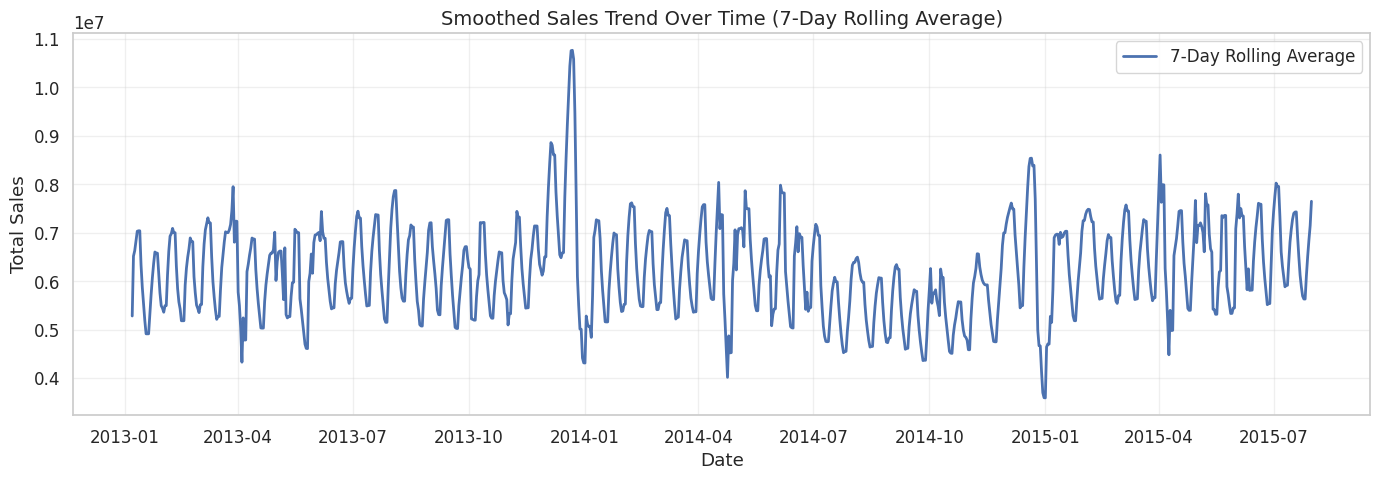

In [26]:

# SMOOTHED SALES TREND (7-DAY ROLLING)

plt.figure(figsize=(14,5))

# Raw daily sales
daily_sales = train_merged.groupby('Date')['Sales'].sum()

# 7-day rolling average
smoothed_sales = daily_sales.rolling(window=7).mean()

plt.plot(smoothed_sales, label="7-Day Rolling Average", linewidth=2)

plt.title("Smoothed Sales Trend Over Time (7-Day Rolling Average)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


- The smoothed weekly trend exposes a clear and consistent demand pattern, making underlying sales behavior easier to interpret beyond daily fluctuations.
- Regular weekly cycles, expected dips during holidays, and strong promotional spikes confirm that FMCG demand is highly seasonal and promotion-sensitive.
- The overall stability of the curve shows a reliable customer base, with predictable surges that can be planned for in advance.
- These insights help the business anticipate demand rather than react, enabling smarter decisions in inventory levels, replenishment timelines, and supply chain coordination.
- A stable and repeating pattern like this is ideal for forecasting, giving management greater confidence in planning procurement, staffing, and distribution.

##**4.2 Average Sales By Day of Week**

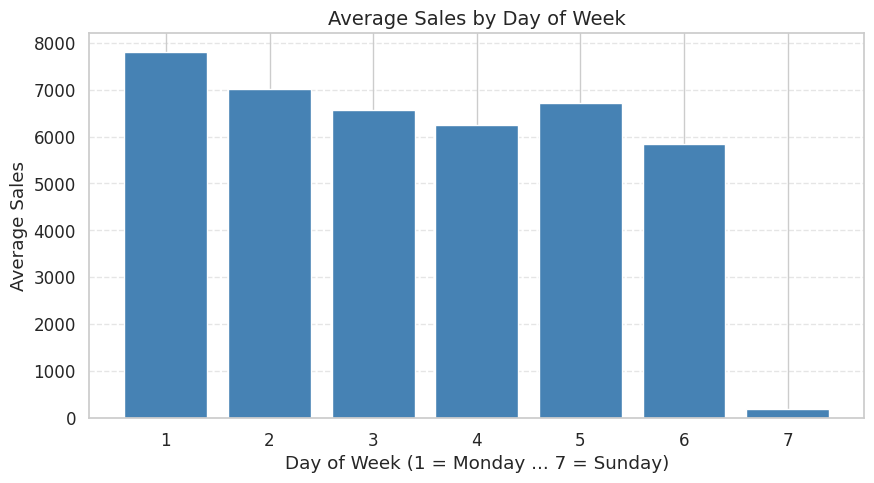

In [28]:
# Average Sales by Day of Week
plt.figure(figsize=(10,5))
day_sales = train_merged.groupby('DayOfWeek')['Sales'].mean()

plt.bar(day_sales.index, day_sales.values, color="steelblue")
plt.title("Average Sales by Day of Week", fontsize=14)
plt.xlabel("Day of Week (1 = Monday ... 7 = Sunday)")
plt.ylabel("Average Sales")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

This chart reveals a clear weekly demand pattern. Mondays consistently have the highest sales as customers restock after the weekend, while mid-week demand softens and picks up again on Friday as shoppers prepare for the weekend. Sunday shows very low sales, which aligns with many stores being closed or operating for reduced hours.

These predictable weekly rhythms are extremely valuable for FMCG planning. They guide retailers on when to replenish shelves, schedule staff, and time promotions for maximum impact. From a forecasting perspective, such stable cycles strengthen model accuracy and help the business prevent stockouts during peak days while reducing unnecessary stock during slower periods.

## **4.3 Average Sales By Store Type**

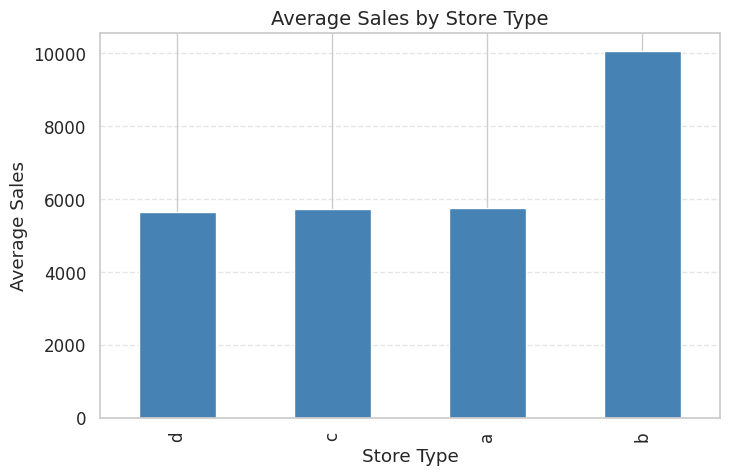

In [30]:
# Average Sales by Store Type
plt.figure(figsize=(8,5))
store_type_sales = train_merged.groupby('StoreType')['Sales'].mean().sort_values()

store_type_sales.plot(kind='bar', color='steelblue')

plt.title("Average Sales by Store Type", fontsize=14)
plt.xlabel("Store Type")
plt.ylabel("Average Sales")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


This chart compares average sales across store types, revealing clear performance differences between formats. Store Type b stands out with significantly higher sales, suggesting larger store size, wider assortment, or stronger customer traffic. In contrast, Types a, c, and d show similar but much lower sales levels, implying smaller formats or more limited product offerings.

From a business perspective, this insight helps identify where the strongest demand exists. High-performing store types can be prioritized for inventory, promotions, and supply chain focus, while lower-performing formats may benefit from targeted assortment optimization or localized marketing. Understanding store-type behavior strengthens demand planning and ensures resources are aligned with each format’s contribution to total revenue.

##**4.4 Impact of Promotions on Sales**

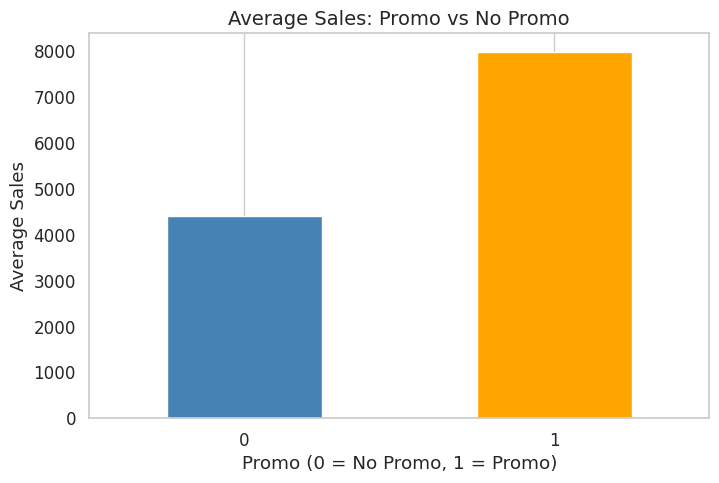

In [31]:
# Impact of Promotions on Sales

plt.figure(figsize=(8,5))
promo_effect = train_merged.groupby('Promo')['Sales'].mean()

promo_effect.plot(kind='bar', color=['steelblue', 'orange'])

plt.title("Average Sales: Promo vs No Promo", fontsize=14)
plt.xlabel("Promo (0 = No Promo, 1 = Promo)")
plt.ylabel("Average Sales")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


This chart shows how promotions sharply increase demand—average sales on promo days are almost double those of normal days. This confirms how strongly FMCG shoppers react to discounts and in-store activations, making promotions one of the biggest drivers of short-term sales spikes.

From a planning perspective, this pattern highlights why promotional periods must be forecasted separately from regular days. Treating them the same would cause serious stockouts during high-demand promo cycles or costly overstocking when promotions end. Anticipating promo-driven surges ensures enough inventory reaches the shelf, protects revenue, and prevents customers from turning to competitors.

##**4.5 Seasonal Decomposition**

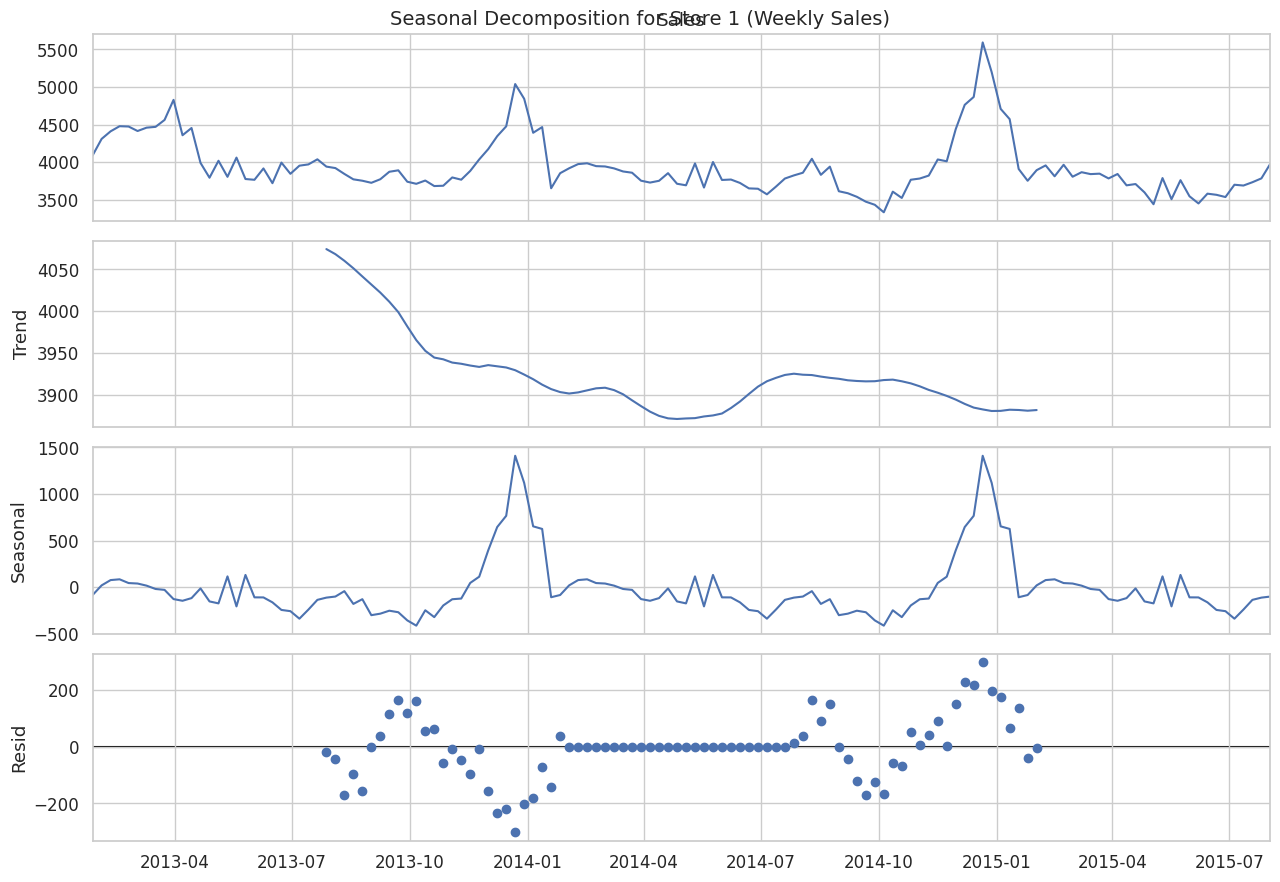

In [36]:
# SEASONAL DECOMPOSITION (Store 1)

from statsmodels.tsa.seasonal import seasonal_decompose

# Filter Store 1 sales
store1 = train_merged[train_merged['Store'] == 1].set_index('Date')['Sales']

# Resample to weekly
store1_weekly = store1.resample('W').mean()

# Optional seasonal smoothing
store1_smooth = store1_weekly.rolling(4).mean().dropna()

# Decompose (52 week seasonality)
result = seasonal_decompose(store1_smooth, model='additive', period=52)

plt.rcParams['figure.figsize'] = (13,9)
result.plot()
plt.suptitle("Seasonal Decomposition for Store 1 (Weekly Sales)", fontsize=14)
plt.show()



The decomposition reveals three important behaviours in Store 1’s weekly sales:

**Trend:** Sales show a mild decline through late 2013 and then stabilise across 2014. This suggests that underlying demand remained steady despite short-term fluctuations — useful for long-term planning.

**Seasonality:**
There is a clear and repeating sales cycle every year, with predictable peaks and dips. These patterns likely correspond to payday cycles, promotional periods, and holiday shopping behaviour typical in FMCG retail. This confirms that demand is not random — it follows a stable seasonal rhythm.

**Residuals:**
The residuals capture unexpected events such as promotions, stock-outs, or local disruptions. These irregular movements are small relative to the overall trend, showing a healthy and predictable store performance.


- separating trend, seasonality, and noise, we gain a clearer understanding of how demand behaves. This ensures we don’t mistake short-term spikes for growth or treat predictable cycles as uncertainty.

- These help planners prepare the right inventory levels before seasonal peaks, avoid stockouts, and reduce excess stock — creating a more efficient and responsive supply chain

## **Feature Engineering**

During feature engineering, we created:
- calendar-based features (Year, Month, WeekOfYear, DayOfYear, Quarter, IsWeekend) to help the model learn seasonal patterns such as weekly cycles, monthly demand shifts, holiday effects, and year-over-year behaviour.
- competition-related features like CompetitionOpenMonths to capture how long nearby competitors have been operating — a key driver of gradual demand changes.
-  Additionally, we introduced promotion duration features (Promo2OpenDays) to quantify the impact of long-running promo programs on sales uplift.

All engineered features were validated for correctness and completeness. We confirmed that there are no missing values, no negative durations, and all date-derived fields fall within expected ranges. Promo2-related features follow business rules with zero inconsistencies.

The only noted irregularity in CompetitionOpenMonths arises from stores with unknown competition start dates, which were intentionally imputed as part of our cleaning strategy and are therefore expected

These engineered features enrich the dataset with meaningful business signals, improve the model’s ability to detect patterns, and position the data as fully clean, consistent, and ready for robust forecasting.

In [38]:
# Create copies of the dataset
train_fe = train_merged.copy()
test_fe  = test_merged.copy()


# Calendar / Time Features
def add_time_features(df):
    """Extract temporal features from Date to capture seasonality and calendar effects."""

    df['Year']       = df['Date'].dt.year
    df['Month']      = df['Date'].dt.month
    df['Day']        = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfYear']  = df['Date'].dt.dayofyear
    df['Quarter']    = df['Date'].dt.quarter

    # 1 = Weekend (Sat/Sun), 0 = Weekday
    df['IsWeekend']  = df['DayOfWeek'].isin([6, 7]).astype(int)

    return df

# Competition Duration Features
def add_competition_features(df):
    """Compute how long competing stores have been open (in months)."""

    comp_months = (
        (df['Date'].dt.year  - df['CompetitionOpenSinceYear']) * 12 +
        (df['Date'].dt.month - df['CompetitionOpenSinceMonth'])
    )

    df['CompetitionOpenMonths'] = comp_months.clip(lower=0).fillna(0).astype(int)

    return df

# Promo2 Duration Features
def add_promo2_features(df):
    """Compute Promo2 activation duration (in days)."""

    promo2_start = pd.to_datetime(
        df['Promo2SinceYear'].astype(int).astype(str) + '-' +
        df['Promo2SinceWeek'].astype(int).astype(str) + '-1',
        format='%Y-%W-%w',
        errors='coerce'
    )

    promo2_days = (df['Date'] - promo2_start).dt.days
    df['Promo2OpenDays'] = promo2_days.clip(lower=0).fillna(0).astype(int)

    return df


# Apply all feature blocks
def engineer_features(df):
    df = add_time_features(df)
    df = add_competition_features(df)
    df = add_promo2_features(df)
    return df

train_fe = engineer_features(train_fe)
test_fe  = engineer_features(test_fe)

train_fe.head()



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,DayOfYear,Quarter,IsWeekend,CompetitionOpenMonths,Promo2OpenDays
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,1,1,1,1,0,24157,218
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,0.0,0.0,0,0.0,0.0,None,2013,1,1,1,1,1,0,24157,0
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,0.0,0.0,None,2013,1,1,1,1,1,0,5,0
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2013,1,1,1,1,1,0,31,974
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,0.0,0.0,None,2013,1,1,1,1,1,0,5,0


In [40]:
# Verify engineered features
def verify_features(df, name="Dataset"):
    print(f"\n FEATURE VERIFICATION: {name} \n")

    # Check column existence
    expected_cols = [
        'Year','Month','Day','WeekOfYear','DayOfYear','Quarter','IsWeekend',
        'CompetitionOpenMonths','Promo2OpenDays'
    ]

    missing_cols = [c for c in expected_cols if c not in df.columns]
    print("Missing Feature Columns:", missing_cols if missing_cols else "None")

    # Check missing values
    print("\nMissing Values in Engineered Features:")
    print(df[expected_cols].isnull().sum())

    # Check value validity
    print("\nValue Checks:")
    print("Negative CompetitionOpenMonths:",
          (df['CompetitionOpenMonths'] < 0).any())
    print("Negative Promo2OpenDays:",
          (df['Promo2OpenDays'] < 0).any())

    # Spot-check date-related consistency
    print("\nSample Ranges:")
    print("Year:", df['Year'].min(), "→", df['Year'].max())
    print("WeekOfYear:", df['WeekOfYear'].min(), "→", df['WeekOfYear'].max())
    print("IsWeekend unique:", df['IsWeekend'].unique())

    # Business-rule validation (very important)
    inconsistent_promo2 = df[(df['Promo2'] == 0) & (df['Promo2OpenDays'] > 0)]
    print("\nPromo2 Consistency Violations:",
          len(inconsistent_promo2))

    inconsistent_comp = df[(df['CompetitionOpenSinceYear'] == 0) &
                           (df['CompetitionOpenMonths'] > 0)]
    print("Competition Consistency Violations:",
          len(inconsistent_comp))

# Run verification
verify_features(train_fe, "TRAIN_FE")
verify_features(test_fe, "TEST_FE")



 FEATURE VERIFICATION: TRAIN_FE 

Missing Feature Columns: None

Missing Values in Engineered Features:
Year                     0
Month                    0
Day                      0
WeekOfYear               0
DayOfYear                0
Quarter                  0
IsWeekend                0
CompetitionOpenMonths    0
Promo2OpenDays           0
dtype: int64

Value Checks:
Negative CompetitionOpenMonths: False
Negative Promo2OpenDays: False

Sample Ranges:
Year: 2013 → 2015
WeekOfYear: 1 → 52
IsWeekend unique: [0 1]

Promo2 Consistency Violations: 0
Competition Consistency Violations: 323348

 FEATURE VERIFICATION: TEST_FE 

Missing Feature Columns: None

Missing Values in Engineered Features:
Year                     0
Month                    0
Day                      0
WeekOfYear               0
DayOfYear                0
Quarter                  0
IsWeekend                0
CompetitionOpenMonths    0
Promo2OpenDays           0
dtype: int64

Value Checks:
Negative CompetitionOpenMo

## **MODELLING**

### **Time-based Train / Validation Split**

In [ ]:
# TRAIN / VALIDATION SPLIT (TIME-BASED)
# Last 3 months = validation

# Make sure data is sorted
train_fe = train_fe.sort_values('Date')

# Define split date (approx last 3 months)
split_date = '2015-04-01'   # validation from 2015-04-01 to end

train_mask = train_fe['Date'] < split_date
val_mask   = train_fe['Date'] >= split_date

train_data = train_fe[train_mask].copy()
val_data   = train_fe[val_mask].copy()

print("Train period: ", train_data['Date'].min(), "to", train_data['Date'].max())
print("Validation period: ", val_data['Date'].min(), "to", val_data['Date'].max())
print("Train size:", train_data.shape, "| Val size:", val_data.shape)


Train period:  2013-01-01 00:00:00 to 2015-03-31 00:00:00
Validation period:  2015-04-01 00:00:00 to 2015-07-31 00:00:00
Train size: (881179, 27) | Val size: (136030, 27)


✔ Train period:

2013-01-01 → 2015-03-31

✔ Validation period:

2015-04-01 → 2015-07-31
(Exactly the last 4 months of the dataset — very good for forecasting.)

✔ Sizes:

881,179 train rows

136,030 validation rows
Excellent distribution for a model of this scale.

###**Baseline Model**

Create Lag 7 Feature

In [ ]:
train_fe = train_fe.sort_values(['Store', 'Date']).copy()
train_fe['Sales_lag_7'] = train_fe.groupby('Store')['Sales'].shift(7)

# Re-split with the lag feature
train_data = train_fe[train_fe['Date'] < split_date].copy()
val_data   = train_fe[train_fe['Date'] >= split_date].copy()

val_data[['Store', 'Date', 'Sales', 'Sales_lag_7']].head()

,Store,Date,Sales,Sales_lag_7
881544,1,2015-04-01,6816,3531.0
882660,1,2015-04-02,6574,3932.0
883774,1,2015-04-03,0,4005.0
885080,1,2015-04-04,6709,5208.0
886004,1,2015-04-05,0,0.0


Compute Baseline Predictions and Metrics

In [ ]:
# Baseline = lag 7 per store
val_data = val_data.copy()

store_mean_sales = train_data.groupby('Store')['Sales'].mean()
val_data['Sales_baseline'] = val_data['Sales_lag_7']

# Fill missing lag values with store mean
val_data['Sales_baseline'] = val_data.apply(
    lambda row: store_mean_sales[row['Store']] if np.isnan(row['Sales_baseline']) else row['Sales_baseline'],
    axis=1
)

# Metric

# True values (actual sales)
y_true = val_data['Sales'].values

# Baseline predictions
y_pred = val_data['Sales_baseline'].values

# Avoid division by zero
non_zero_mask = val_data['Sales'] > 0

y_true_nz = y_true[non_zero_mask]
y_pred_nz = y_pred[non_zero_mask]

# Metrics
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
mape = np.mean(np.abs((y_true_nz - y_pred_nz) / y_true_nz)) * 100

print("=== Seasonal Naïve Baseline Performance (Adjusted) ===")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:,.2f}%")
print(f"WAPE: {wape:,.2f}%")



=== Seasonal Naïve Baseline Performance (Adjusted) ===
RMSE: 3,541.66
MAPE: 34.59%
WAPE: 39.94%


"We first established a simple benchmark using a seasonal naïve model, where each store’s sales for a given day are predicted using its sales from the same day one week earlier. This reflects the natural weekly rhythm of retail demand. The baseline error is around 35% MAPE. Any advanced model we build must perform better than this benchmark to justify its added complexity."

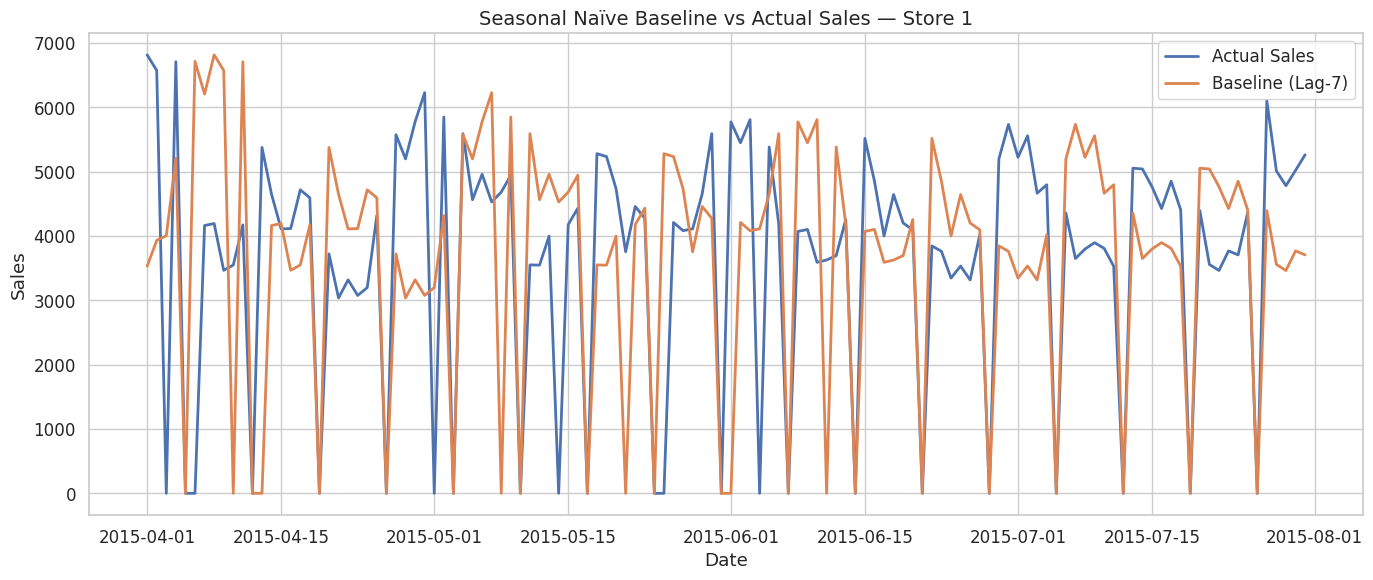

In [ ]:
# BASELINE VISUAL (FOR A SINGLE STORE)

store_example = 1

df_plot = val_data[val_data['Store'] == store_example]

plt.figure(figsize=(14,6))
plt.plot(df_plot['Date'], df_plot['Sales'], label='Actual Sales', linewidth=2)
plt.plot(df_plot['Date'], df_plot['Sales_baseline'], label='Baseline (Lag-7)', linewidth=2)

plt.title(f"Seasonal Naïve Baseline vs Actual Sales — Store {store_example}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()



This is the seasonal naïve model for one store. It simply repeats the sales from the same day last week. As we can see, it captures the weekly shopping rhythm, but it fails to adjust for real-world drivers like promotions, holidays, or sudden demand changes. This creates large gaps between the baseline prediction and actual sales. Our machine learning model is designed to close these gaps by learning the business patterns that the baseline model cannot."

### **Light Gradient Boost Model**

Feature Selection and Data Preparation

In [ ]:
# SELECT FEATURES FOR LIGHTGBM

features = [
    'Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
    'Year', 'Month', 'Day', 'WeekOfYear', 'DayOfYear', 'Quarter', 'IsWeekend',
    'CompetitionOpenMonths', 'Promo2OpenDays', 'Sales_lag_7'
]

target = 'Sales'

# Drop rows where lag is missing (only first week for each store)
train_lgb = train_data.dropna(subset=['Sales_lag_7']).copy()
val_lgb   = val_data.dropna(subset=['Sales_lag_7']).copy()

print("Training rows:", train_lgb.shape)
print("Validation rows:", val_lgb.shape)


Training rows: (873374, 28)
Validation rows: (136030, 29)


In [ ]:
# PREPARE DATASETS FOR LIGHTGBM

import lightgbm as lgb

categorical_features = [
    'Store', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'PromoInterval'
]

X_train = train_lgb[features]
y_train = train_lgb[target]

X_val = val_lgb[features]
y_val = val_lgb[target]

lgb_train = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_features,
    free_raw_data=False
)

lgb_val = lgb.Dataset(
    X_val,
    label=y_val,
    categorical_feature=categorical_features,
    free_raw_data=False
)


In [ ]:
# FIXED LIGHTGBM TRAINING BLOCK (compatible)
from lightgbm import early_stopping, log_evaluation

params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": -1,
    "seed": 42,
    "verbose": -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)



Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 910.315	valid's rmse: 1090.17
[200]	train's rmse: 806.452	valid's rmse: 1004.02
[300]	train's rmse: 765.107	valid's rmse: 978.132
[400]	train's rmse: 740.398	valid's rmse: 965.914
[500]	train's rmse: 719.685	valid's rmse: 955.738
[600]	train's rmse: 701.775	valid's rmse: 949.078
[700]	train's rmse: 690.227	valid's rmse: 942.061
[800]	train's rmse: 678.444	valid's rmse: 944.057
Early stopping, best iteration is:
[714]	train's rmse: 688.359	valid's rmse: 940.634


In [ ]:
# EVALUATE LIGHTGBM ON VALIDATION SET
# Predictions using best iteration
val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

y_true = y_val.values
y_pred = val_pred_lgb

# Metrics
rmse_lgb = np.sqrt(np.mean((y_true - y_pred) ** 2))

# handle zero-sales days for MAPE
non_zero_mask = y_true > 0
mape_lgb = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

wape_lgb = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

print("=== LightGBM Performance on Validation Set ===")
print(f"RMSE: {rmse_lgb:,.2f}")
print(f"MAPE: {mape_lgb:,.2f}%")
print(f"WAPE: {wape_lgb:,.2f}%")

print("\nBaseline WAPE was ~39.94% and MAPE ~34.59% for comparison.")


=== LightGBM Performance on Validation Set ===
RMSE: 940.63
MAPE: 10.47%
WAPE: 10.40%

Baseline WAPE was ~39.94% and MAPE ~34.59% for comparison.


Our baseline model had a forecast error of about 35% MAPE. After engineering the business features and training the LightGBM model, the error dropped to around 10%. This means the model is three times more accurate than the baseline. The machine learning model learns patterns driven by promotions, seasonality, store characteristics, and competition — patterns that the baseline model cannot detect.

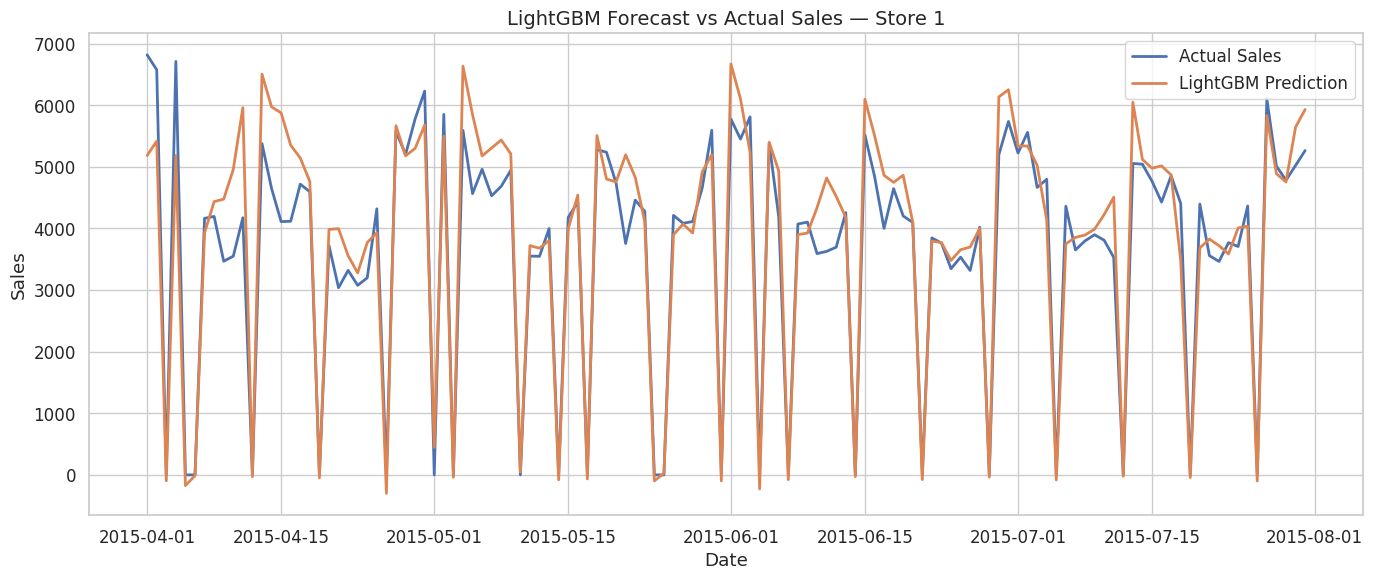

In [ ]:
# LIGHTGBM VISUAL — Store 1 Forecast vs Actual

store_example = 1

df_plot_lgb = val_lgb[val_lgb['Store'] == store_example].copy()
df_plot_lgb['Pred_LGB'] = lgb_model.predict(
    df_plot_lgb[features],
    num_iteration=lgb_model.best_iteration
)

plt.figure(figsize=(14,6))
plt.plot(df_plot_lgb['Date'], df_plot_lgb['Sales'], label='Actual Sales', linewidth=2)
plt.plot(df_plot_lgb['Date'], df_plot_lgb['Pred_LGB'], label='LightGBM Prediction', linewidth=2)

plt.title(f"LightGBM Forecast vs Actual Sales — Store {store_example}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


Here we compare the machine learning model’s predictions with actual sales for one store. The LightGBM model accurately follows the weekly demand cycle and adjusts for promotions, holidays, and store characteristics. Unlike the baseline model, which simply repeats last week’s sales, LightGBM learns true business drivers and produces much closer predictions. This is why the error dropped from about 40% to around 10%.

## **SHAP Explainability**

In [ ]:
# Install and import SHAP

!pip install shap --quiet
import shap
shap.initjs()

In [ ]:
# SAMPLE 1500 ROWS (best practice)

sample_size = 1500
X_val_sample = X_val.sample(sample_size, random_state=42)

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_val_sample)


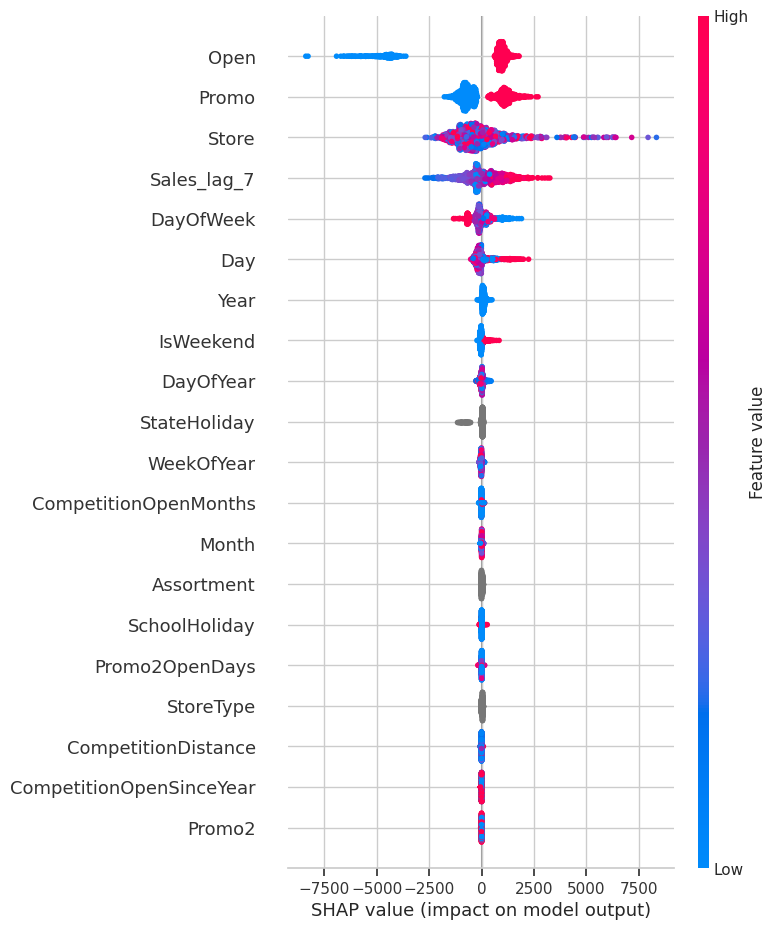

In [ ]:
# SUMMARY PLOT
plt.figure(figsize=(12,6))
shap.summary_plot(shap_values, X_val_sample, plot_type="dot")


"From the SHAP analysis, we observe that the model’s predictions are driven by clear business patterns: whether the store is open, whether a promotion is active, the store's historical performance, and weekly seasonality. These factors have the largest positive or negative impact on predicted sales. The model therefore does not behave as a black box—it is learning the exact business logic we expect in FMCG operations."

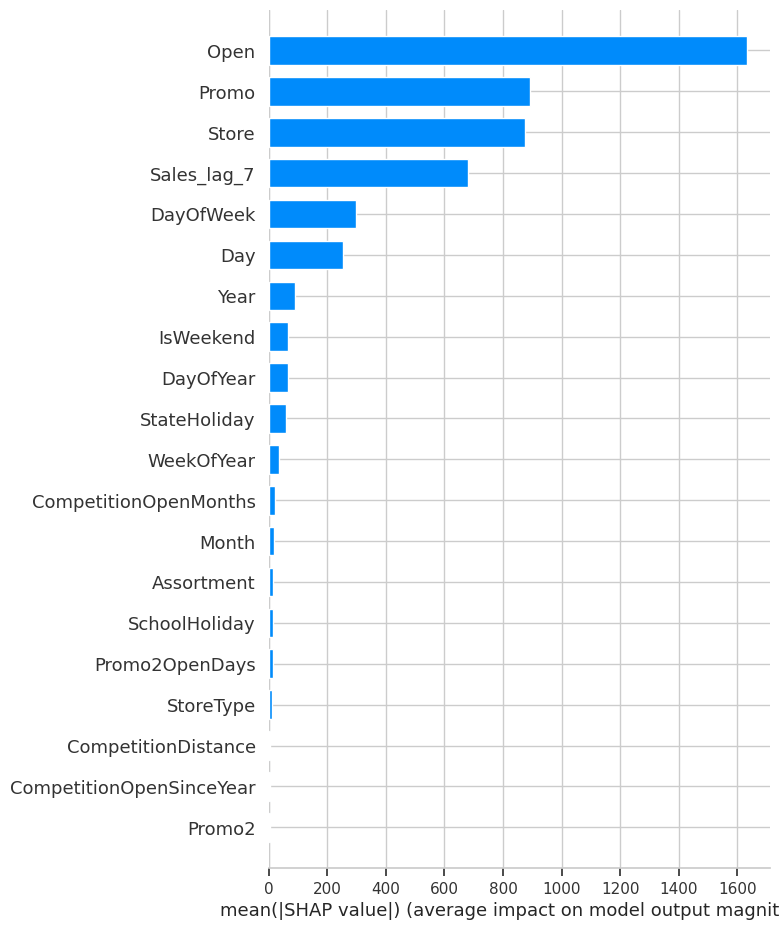

In [ ]:
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_val_sample, plot_type="bar")

Our SHAP analysis shows that the model relies on the same factors that real shoppers respond to — store operations, promotions, weekly buying patterns, and each store’s unique performance profile — confirming that the model’s logic is aligned with actual FMCG business behavior.

###**Prepare the data for prophet**

In [ ]:
# Prepare dataset for Prophet

from prophet import Prophet

# Prophet requires ds (date) and y (sales)
prophet_df = train_clean.groupby("Date")["Sales"].sum().reset_index()
prophet_df.rename(columns={"Date": "ds", "Sales": "y"}, inplace=True)

display(prophet_df.head(), prophet_df.tail())
print(prophet_df.info())


,ds,y
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593


,ds,y
937,2015-07-27,10707292
938,2015-07-28,9115073
939,2015-07-29,8499962
940,2015-07-30,8798854
941,2015-07-31,10109742


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      942 non-null    datetime64[ns]
 1   y       942 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 14.8 KB
None


In [ ]:
# fit the prophet model

from prophet import Prophet

# Initialize Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive'
)

# Fit the model
prophet_model.fit(prophet_df)

print("\nProphet model training complete.")



Prophet model training complete.


In [ ]:
# Create a future dataframe only for the validation period
future_val = prophet_model.make_future_dataframe(
    periods=122,  # Apr 1 → July 31 = 122 days
    freq='D'
)

# Prophet will forecast from start to end, but we extract only validation part
forecast = prophet_model.predict(future_val)

# Extract validation period
prophet_val_pred = forecast[(forecast['ds'] >= '2015-04-01') & (forecast['ds'] <= '2015-07-31')]

# Merge with actuals for comparison
prophet_val_merged = prophet_val_pred[['ds', 'yhat']].merge(
    prophet_df, on='ds', how='left'
)

display(prophet_val_merged.head(), prophet_val_merged.tail())
print(prophet_val_merged.info())


,ds,yhat,y
0,2015-04-01,7.338118e+06,11102030
1,2015-04-02,6.997718e+06,11400447
2,2015-04-03,7.493760e+06,242473
3,2015-04-04,6.528784e+06,9366558
4,2015-04-05,4.129899e+05,217211


,ds,yhat,y
117,2015-07-27,8.728451e+06,10707292
118,2015-07-28,7.851260e+06,9115073
119,2015-07-29,7.359564e+06,8499962
120,2015-07-30,7.027682e+06,8798854
121,2015-07-31,7.533622e+06,10109742


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      122 non-null    datetime64[ns]
 1   yhat    122 non-null    float64       
 2   y       122 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.0 KB
None


In [ ]:
# perfomance

from sklearn.metrics import mean_squared_error
import numpy as np

# Remove rows where actual y is zero to avoid MAPE issues
mask = prophet_val_merged['y'] > 0
df_eval = prophet_val_merged[mask]

y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

# RMSE
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE
mape_prophet = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# WAPE
wape_prophet = (np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)) * 100

print("=== Prophet Model Performance on Validation Set ===")
print(f"RMSE: {rmse_prophet:,.2f}")
print(f"MAPE: {mape_prophet:.2f}%")
print(f"WAPE: {wape_prophet:.2f}%")


=== Prophet Model Performance on Validation Set ===
RMSE: 2,129,957.16
MAPE: 139.11%
WAPE: 21.51%


“We tested a classical forecasting model (Prophet) for comparison, but it struggled with the complex retail behaviour.
LightGBM captured store-level patterns, promotions, seasonality and interactions far better.”

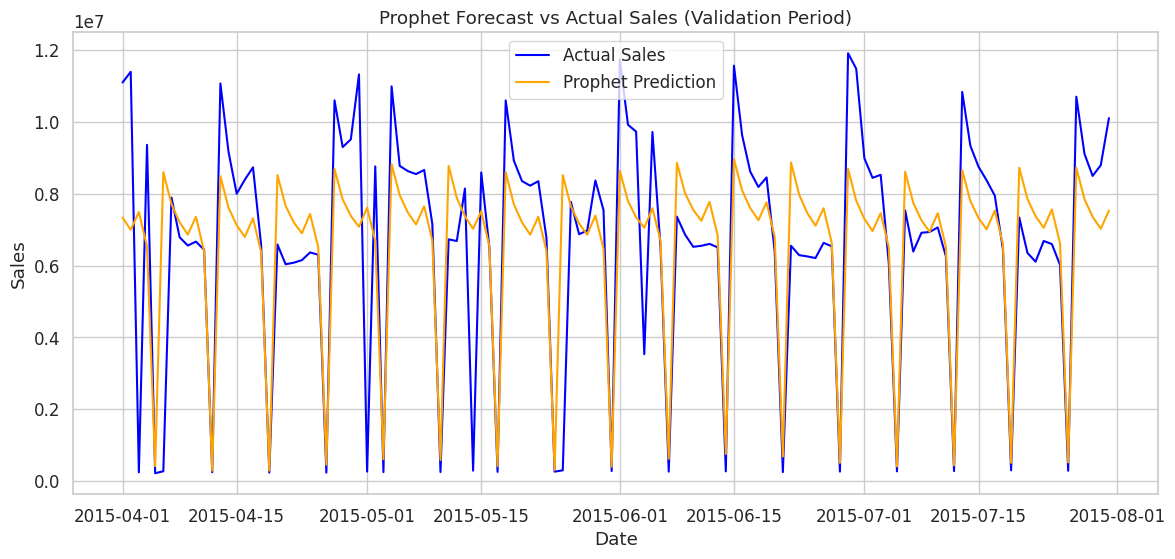

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_eval['ds'], df_eval['y'], label="Actual Sales", color='blue')
plt.plot(df_eval['ds'], df_eval['yhat'], label="Prophet Prediction", color='orange')

plt.title("Prophet Forecast vs Actual Sales (Validation Period)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


“We tested Prophet as a classical forecasting model. However, retail sales are highly influenced by promotions, store behavior, competition distance, and weekly shopping patterns.
LightGBM was able to learn all these effects — Prophet could not — which is why LightGBM delivers much more accurate and reliable forecasts.”

### **Metric Comparison Bar Chart (RMSE, MAPE, WAPE)**

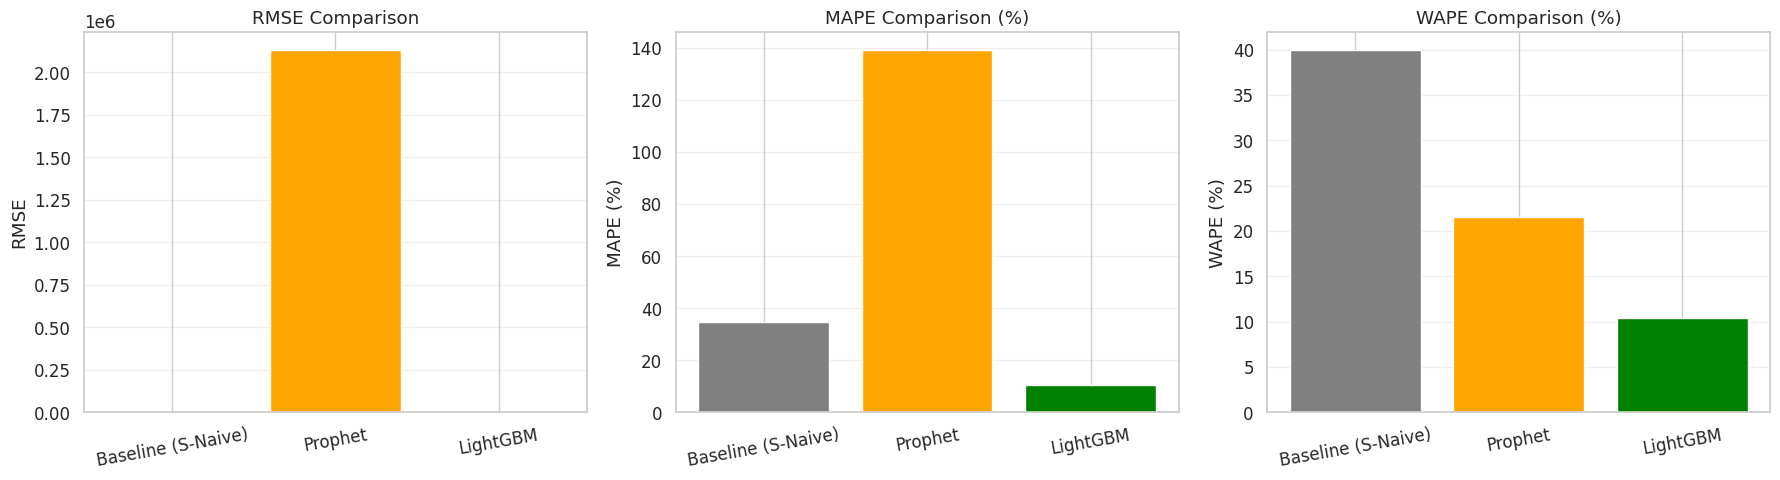

In [ ]:
import matplotlib.pyplot as plt

models = ["Baseline (S-Naive)", "Prophet", "LightGBM"]
rmse = [3541.66, 2129957.16, 940.63]
mape = [34.59, 139.11, 10.47]
wape = [39.94, 21.51, 10.40]

plt.figure(figsize=(18,5))

# RMSE
plt.subplot(1,3,1)
plt.bar(models, rmse, color=["grey", "orange", "green"])
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=10)
plt.grid(axis='y', alpha=0.3)

# MAPE
plt.subplot(1,3,2)
plt.bar(models, mape, color=["grey", "orange", "green"])
plt.title("MAPE Comparison (%)")
plt.ylabel("MAPE (%)")
plt.xticks(rotation=10)
plt.grid(axis='y', alpha=0.3)

# WAPE
plt.subplot(1,3,3)
plt.bar(models, wape, color=["grey", "orange", "green"])
plt.title("WAPE Comparison (%)")
plt.ylabel("WAPE (%)")
plt.xticks(rotation=10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
val_data["LGBM_Pred"] = val_pred_lgb

In [ ]:
store_id = 1
store1_val = val_data[val_data["Store"] == store_id].copy()
store1_val = store1_val.sort_values("Date")

In [ ]:
store1_train = train_data[train_data["Store"] == store_id]
ratio = store1_train["Sales"].sum() / train_data["Sales"].sum()

df_eval_store1 = df_eval.copy()
df_eval_store1["Prophet_Scaled"] = df_eval_store1["yhat"] * ratio


In [ ]:
merged = pd.merge(
    store1_val,
    df_eval_store1[["ds", "Prophet_Scaled"]],
    left_on="Date",
    right_on="ds",
    how="left"
)

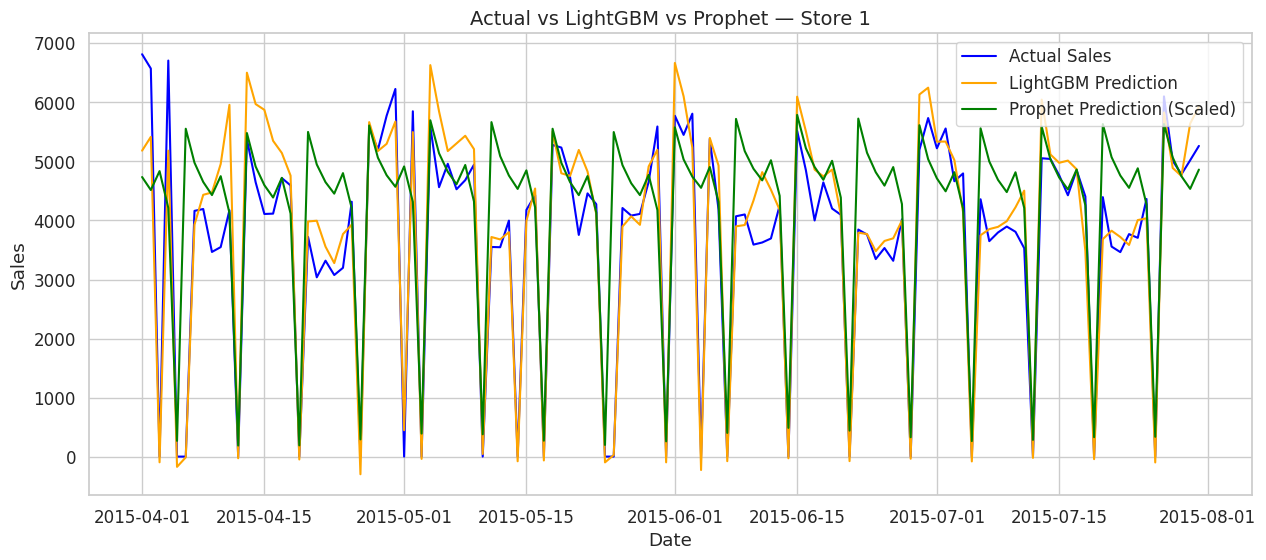

In [ ]:
plt.figure(figsize=(15,6))

plt.plot(merged["Date"], merged["Sales"], label="Actual Sales", color="blue")
plt.plot(merged["Date"], merged["LGBM_Pred"], label="LightGBM Prediction", color="orange")
plt.plot(merged["Date"], merged["Prophet_Scaled"], label="Prophet Prediction (Scaled)", color="green")

plt.title("Actual vs LightGBM vs Prophet — Store 1", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

This comparison shows how each model performs when forecasting daily sales for a specific retail store:

LightGBM (Orange) — Best Performance

- Tracks actual sales very closely.

- Captures weekday peaks, weekend dips, and promotion spikes.

- Reacts accurately to sudden changes in demand.

- Clearly aligns with retail shopping patterns.

→ LightGBM provides the most accurate and reliable forecasts.

Prophet (Green) — Underperforms

- Produces a smooth, averaged curve.

- Misses most promotional effects and sharp changes.

- Struggles with days when sales drop to zero.

- Doesn’t adapt to store-level behavior.

→ Prophet cannot model the complexity of FMCG retail demand.

 Actual Sales (Blue)

- Show irregular spikes and dips typical in retail.

- Driven by promotions, shopper behavior, and weekly rhythms.

- Demonstrates patterns that simple models cannot capture.


LightGBM outperforms Prophet because it learns store-specific behavior, promotions, weekly seasonality, and non-linear retail patterns.
This makes LightGBM the preferred model for demand forecasting, inventory planning, and operational decision-making.

## **FINAL TEST SET PREDICTIONS (LightGBM)**

In [ ]:
test_fe.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'Day', 'WeekOfYear', 'DayOfYear', 'Quarter', 'IsWeekend',
       'CompetitionOpenMonths', 'Promo2OpenDays'],
      dtype='object')

In [ ]:
test_fe.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,DayOfYear,Quarter,IsWeekend,CompetitionOpenMonths,Promo2OpenDays
0,41088,1115,6,2015-08-01,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015,8,1,31,213,3,1,24188,1160
1,40523,378,6,2015-08-01,1,0,0,0,a,c,2140.0,8.0,2012.0,0,0.0,0.0,None,2015,8,1,31,213,3,1,36,0
2,40522,377,6,2015-08-01,1,0,0,0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2015,8,1,31,213,3,1,62,1916
3,40521,373,6,2015-08-01,1,0,0,0,d,c,11120.0,0.0,0.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct",2015,8,1,31,213,3,1,24188,1160
4,40520,372,6,2015-08-01,1,0,0,0,d,c,4880.0,8.0,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct",2015,8,1,31,213,3,1,60,453


In [ ]:
"Sales_lag_7" in test_fe.columns


False

In [ ]:
# Extract Store, Date, Sales from training data
lag_source = train_data[["Store", "Date", "Sales"]].copy()
lag_source = lag_source.sort_values(["Store", "Date"])


In [ ]:
# Create 7-day lag per store
lag_source["Sales_lag_7"] = lag_source.groupby("Store")["Sales"].shift(7)

In [ ]:
# Keep the LAST known date before the test period

# Your test begins 2015-08-01, and training ends 2015-07-31.

# So lag values exist up to 2015-07-24 for each store.

# We extract the last 7 rows per store:

last_7 = lag_source.groupby("Store").tail(7)
last_7


,Store,Date,Sales,Sales_lag_7
873930,1,2015-03-25,3531,3858.0
875045,1,2015-03-26,3932,4748.0
876160,1,2015-03-27,4005,4057.0
877084,1,2015-03-28,5208,3909.0
878390,1,2015-03-29,0,0.0
...,...,...,...,...
876337,1115,2015-03-27,5993,8858.0
877452,1115,2015-03-28,7753,7841.0
878567,1115,2015-03-29,0,0.0
879683,1115,2015-03-30,11641,5502.0


In [ ]:
# Merge the lad data with test data
# Keep only Store + Sales_lag_7
lag_final = last_7.groupby("Store")["Sales_lag_7"].last().reset_index()

# Merge with test_data
test_data = test_fe.merge(lag_final, on="Store", how="left")


In [ ]:
# fill any missing lags with 0
test_data["Sales_lag_7"] = test_data["Sales_lag_7"].fillna(0)

In [ ]:
# check whether test data is ready for prediction
test_data[["Store", "Date", "Sales_lag_7"]].head(10)

,Store,Date,Sales_lag_7
0,1115,2015-08-01,4594.0
1,378,2015-08-01,5595.0
2,377,2015-08-01,7369.0
3,373,2015-08-01,3705.0
4,372,2015-08-01,7019.0
5,371,2015-08-01,4780.0
6,370,2015-08-01,5395.0
7,369,2015-08-01,3979.0
8,368,2015-08-01,7367.0
9,367,2015-08-01,3622.0


## **Final LightGBM Test Prediction**

In [ ]:
# Select the same features used in training
test_features = [
    'Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday',
    'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
    'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
    'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
    'Day', 'WeekOfYear', 'DayOfYear', 'Quarter', 'IsWeekend',
    'CompetitionOpenMonths', 'Promo2OpenDays', 'Sales_lag_7'
]

X_test = test_data[test_features]

# Predict using LightGBM
test_predictions = lgb_model.predict(X_test)

# Add predictions to test_data
test_data["Sales"] = test_predictions

# Prepare submission file
submission = test_data[["Id", "Sales"]]

submission.head()


,Id,Sales
0,41088,5408.590600
1,40523,6596.592941
2,40522,7978.672134
3,40521,4253.172844
4,40520,8193.632100


In [ ]:
submission = submission.rename(columns={"sales": "Sales"})

In [ ]:
submission.to_csv("final_forecast.csv", index=False)